# Magnetic Susceptibility differences and Iron gene expression levels in GTS.

* Objective is to examine association between Striatal Magnetic Susceptibility statistical maps and the expression of iron-related gene-sets. 
<br><br>

* Analysis driven by         
    * **Romme, Biological Psychiatry, 2017:** Connectome Disconnectivity and Cortical Gene Expression in Patients With Schizophrenia
    * **Whitaker, PNAS, 2016:** Adolescence is associated with genomically patterned consolidation of the hubs of the human brain connectome.
    * **Wong, Cerebral Cortex, 2017:** Inter-Regional Variations in Gene Expression and Age-Related Cortical Thinning in the Adolescent Brain
    * **Shin, Cerebral Cortex, 2016:** Cell-Specific Gene-Expression Profiles and Cortical Thickness in the Human Brain
    * **Romero-Garcia, OHBM, 2017:** Gene expression analysis of structural cortical differences in autism
    * **Richiardi, Science, 2015:** Correlated gene expression supports synchronous activity in brain networks




In [1]:
%matplotlib inline
import os
import math 
import numpy as np
import pandas as pd 
import seaborn as sns
import random
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr, gaussian_kde
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import scale
from statsmodels.sandbox.stats.multicomp import fdrcorrection0
from matplotlib.colors import rgb2hex
pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999

sns.set_style('white')
ahba_dir     = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/AHBA/'
permute_dir  = '/Users/kanaan/Google Drive/TS-EUROTRAIN/RESULTS_QSMv3/dataframes/permutations'
save_fig_dir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Papers/2016_QSM_paper/Figures_python_v4'

drop_strings = ['coords_native', 'donor_names', 'struct_id', 'struct_name', 'top_struct', 
                'Mean', 'Median',  'PC1', 'PC2','PC3', 
                'corrected_mni_x', 'corrected_mni_y', 'corrected_mni_z']

import warnings
warnings.filterwarnings('ignore')

# quality control
# drop wells outside the striatal masks 
drop_wells = [2371, 2379, 159226045, 160091500] 


# Lets be colour-full 

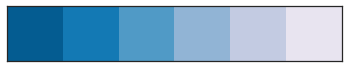

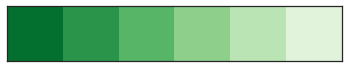

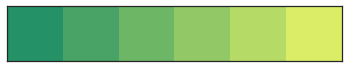

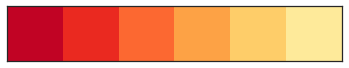

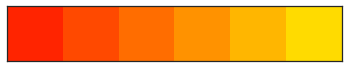

In [101]:
# colours
B = sns.color_palette("PuBu_r")
G = sns.color_palette("Greens_r")
R = sns.color_palette("YlOrRd_r")
S = sns.color_palette("summer")
A = sns.color_palette("autumn")

sns.palplot(B)
sns.palplot(G)
sns.palplot(S)
sns.palplot(R)
sns.palplot(A)


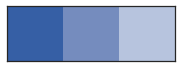

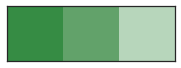

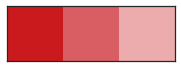

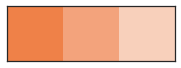

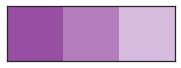

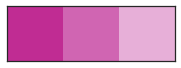

In [99]:
B=['#365fa5', '#758cbe', '#b7c4de']
G=['#368c44', '#62a26a', '#b7d6bb']
R=['#cb1a1e', '#d95e63', '#ecabad']
O=['#ef8148', '#f3a37c', '#f8d0bb']
M=['#984ea3', '#b47ebd', '#d8bcde']
P=['#c02c93', '#d065b2', '#e7afd8']

sns.palplot(sns.color_palette(B))
sns.palplot(sns.color_palette(G))
sns.palplot(sns.color_palette(R))
sns.palplot(sns.color_palette(O))
sns.palplot(sns.color_palette(M))
sns.palplot(sns.color_palette(P))


# Read Geneset Expression Values
* Each dataframe contrains expression values from each sampling well, total wells = 3702 
* Each Well corresponds to an MNI coordinate
* For each gene, expression was calculate as the average of all probes
* 5 principal components were also extracted for each geneset of interest (IRON,IRON_D,ANMC)

In [3]:
def return_expression_df(geneset):
    df = pd.read_csv(os.path.join(ahba_dir, 'AHBA_%s.csv'%geneset),index_col=0)
    gs = [i for i in df.columns if i not in drop_strings]
    return df, gs 

IRON_H,  GS_IRON_H   = return_expression_df('IRON_HOMEOSTASIS_PCA')
IRON_D,  GS_IRON_D   = return_expression_df('IRON_D_PCA')
IRON_T2, GS_IRON_T2  = return_expression_df('IRON_TRANSPORT2_PCA')
FERRITIN,GS_FERRITIN = return_expression_df('FERRITIN_PCA')
IRON_IM, GS_IRON_IM  = return_expression_df('IRON_ION_IMPORT_PCA')
IRON_T1, GS_IRON_T1  = return_expression_df('IRON_TRANSPORT1_PCA')
IRON_R,  GS_IRON_R   = return_expression_df('IRON_RESPONSE_PCA')

genesets = {'IRON_H'  : GS_IRON_H,
            'IRON_D'  : GS_IRON_D,
            'IRON_H'  : GS_IRON_H,
            'IRON_T2' : GS_IRON_T2,
            'FERRITIN': GS_FERRITIN,
            #'IRON_T1' : GS_IRON_T1,
            'IRON_IM' : GS_IRON_IM,
            'IRON_R'  : GS_IRON_R,
           }

# Read QSM statistical map (represents susceptibility [iron] differences)
* The statistical maps represents susceptibility differences between Healthy controls (N=26) and GTS patients (N=23).
* Maps were calculated with a two sample t-test using 10,000 permutations,threshold- free cluster enhancement, and FWE correction.
* ROIs include L/R_Caud, L/R_Putamen, L/R_Pallidum, STR3_MOTOR, STR3_EXEC, STR3_LIMBIC

In [4]:
df_MNI = pd.read_csv(os.path.join(ahba_dir,'QSM_TSTATS/MNI_NIFTI_VALUES_permute_10K_OCT2.csv'), index_col = 0 )

# Concatenate Dataframes

In [102]:
def concat_dfs(measure):
    df  = pd.DataFrame(index = IRON_H.index, columns = ['IRON', 'IRON_D', 'IRON_T2', 'FERRITIN', 'IRON_ION_IMPORT', 
                                                        'IRON_TRANSPORT1', 'IRON_RESPONSE','top_struct', 'struct'])
    xval = 1
    df['top_struct']        = IRON_H.top_struct
    df['struct']            = IRON_H.struct_name
    df['IRON_H']            = IRON_H[measure] * xval
    df['IRON_D']            = IRON_D[measure]
    df['IRON_T2']           = IRON_T2[measure] * xval
    df['FERRITIN']          = FERRITIN[measure] * xval    
    df['IRON_IM']           = IRON_IM[measure] * xval
    df['IRON_T1']           = IRON_T1[measure] * xval
    df['IRON_R']            = IRON_R[measure] * xval
    dfc = pd.concat([df_MNI, df], axis = 1)
    return dfc

df_PC1   = concat_dfs('PC1')
df_PC2   = concat_dfs('PC2')
df_PC3   = concat_dfs('PC3')
df_MU    = concat_dfs('Mean')
df_MD    = concat_dfs('Median')

dfs = {'df_PC1': df_PC1, 'df_MU':df_MU, 'df_MD':df_MD}

In [103]:
df_MU.to_csv(os.path.join(ahba_dir,  'df_geneset_mean.csv'))
df_PC1.to_csv(os.path.join(ahba_dir,  'df_geneset_pc.csv'))


# Fixed Effect Correlations

In [104]:
def detect_outlier_subjects(df,measure,m=2):
    upper = np.mean(df[measure]) + m * np.std(df[measure])
    lower = np.mean(df[measure]) - m * np.std(df[measure])
    outliers = []
    for subject in df.index:
        if df.loc[subject][measure] > upper:
            outliers.append(subject) 
        elif df.loc[subject][measure] < lower:
            outliers.append(subject) 
    #print outliers,measure
    return outliers

def make_corr(DF, met1,met2, color, annotate=0, scatter=1, ci = 95, lstyle='-', lw=3, fname='pc', plot = 1):
    DF = DF
    dfx = pd.DataFrame(index=DF.index)
    dfx[met1]  = scale(DF[met1])  #* 10
    dfx[met2]  = DF[met2]
    
    dfx = dfx.drop(drop_wells ,axis=0).dropna()
    #dfx = dfx.drop([159226077, 127687121],axis=0).dropna()
    r_val = np.round(pearsonr(dfx[met1], dfx[met2])[0],2)
    p_val = np.round(pearsonr(dfx[met1], dfx[met2])[1],10)
    #print len(dfx), r_val, p_val
    
    if p_val < 1:
        print met1, met2[0:6], r_val, p_val
        
        if plot:
            
            grid = sns.JointGrid(met1, met2, data=dfx)#,xlim=xlim, ylim=ylim)#, size=size, ratio=ratio, space=space, #) 
            grid.plot_marginals(sns.distplot, color = color, hist=0, kde = 1, kde_kws={'shade':1})
                                #rug = 1, rug_kws = {'height':0.1})  
            grid.plot_joint(sns.regplot, fit_reg=1, scatter= scatter, color = color, ci = ci,
                           line_kws={'linestyle': lstyle, 'lw':lw}) 
                        #line_kws={'linestyle': lstyle, 'lw':lw}, scatter_kws={"s": 25})
            #sns.jointplot(met1, met2,dfx, kind = 'reg', color=color)
            #plt.vlines(0,5,7.5)
            #plt.set_axis_labels()
            #if annotate:
            #    plt.annotate('R=%s, P=%s' %(r_val, p_val), xy = annotate, fontsize = 13,  color='r')
            plt.xlabel('')
            plt.ylabel('')
            plt.xticks(fontsize=15, weight='bold')
            plt.yticks(fontsize=15, weight='bold')
            #plt.ylim(-.5,1.5)
            #plt.xlim(-30,50)
        
        if fname:
            plt.savefig(os.path.join(save_fig_dir, 'pearson_%s_%s_%s.png' %(met1,met2,fname)), dpi = 300,
                    bbox_inches='tight', transparent = True)

    return dfx


### Geneset-PC1 vs Striatal-Motor Suscspibility reductions 

tstat
IRON_H STR3_M 0.42 0.0009798543
IRON_D STR3_M 0.4 0.0016283418
IRON_T2 STR3_M 0.45 0.0003328754
FERRITIN STR3_M 0.6 7.276e-07


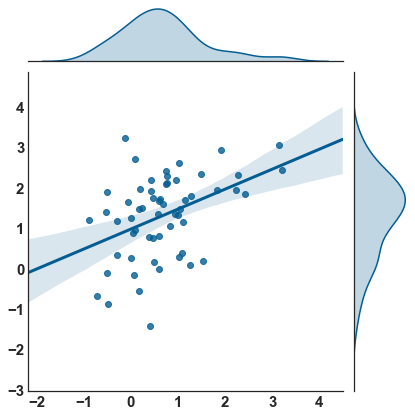

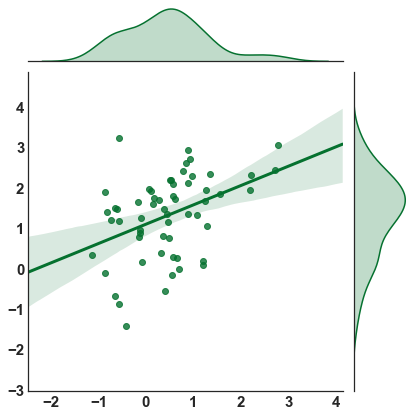

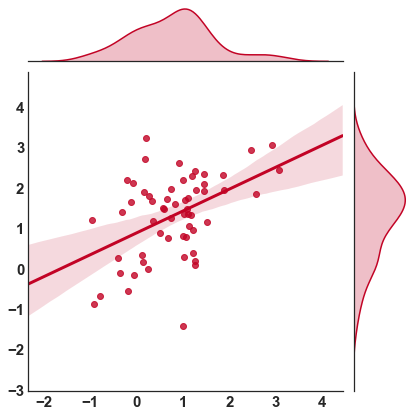

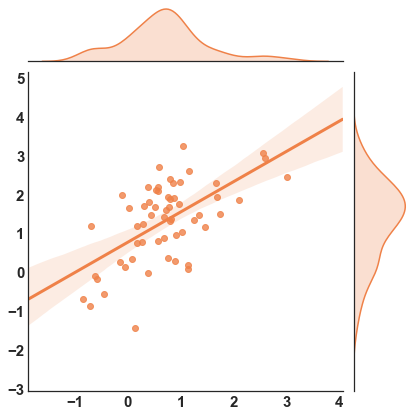

In [106]:
print 'tstat'
df = df_PC1
fname = 'pc'
for roi in ['STR3_MOTOR_tstat_CP_1mm']:
    dfx_iron_h  = make_corr(df,'IRON_H',  roi, B[0], (0.14,1.4), fname=fname)
    dfx_iron_d  = make_corr(df,'IRON_D',  roi, G[0], (0.14,1.4), fname=fname)
    dfx_iron_t2 = make_corr(df,'IRON_T2', roi, R[0], (65,1.4),   fname=fname)
    dfx_ferr    = make_corr(df,'FERRITIN',roi, O[0], (65,1.4),   fname=fname)
    #dfx_iron_im = make_corr(df,'IRON_IM', roi, 'k', (65,1.4),   fname=fname)
    #dfx_iron_r  = make_corr(df,'IRON_R',  roi, 'k', (65,1.4),   fname=fname)


tstat
IRON_H STR3_M 0.27 0.0369281428
IRON_D STR3_M 0.44 0.0004818917
IRON_T2 STR3_M 0.41 0.0012908949
FERRITIN STR3_M 0.54 1.16467e-05


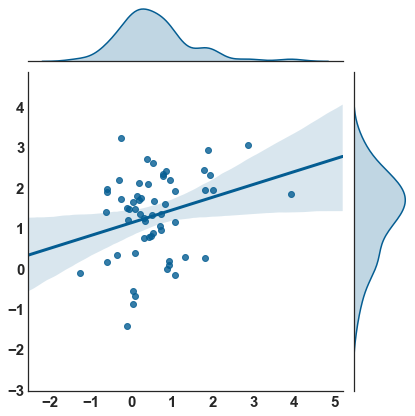

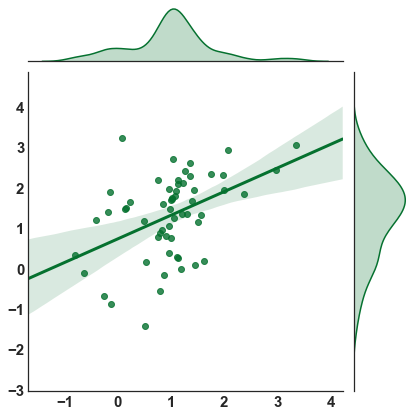

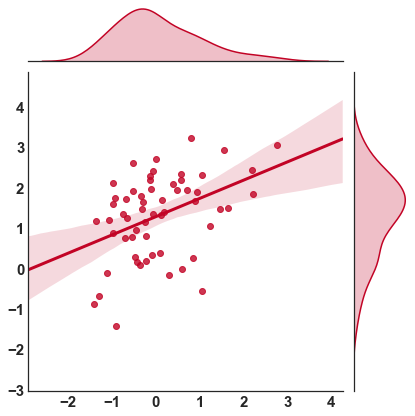

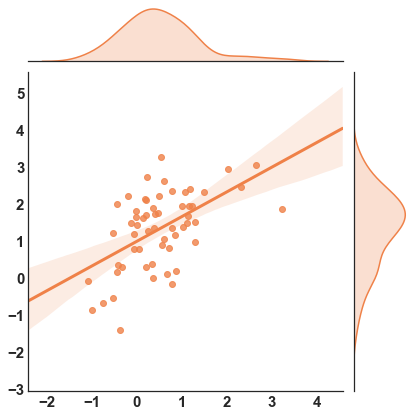

In [110]:
print 'tstat'
df = df_MU
fname = 'mean'
for roi in ['STR3_MOTOR_tstat_CP_1mm']:
    dfx_iron_h  = make_corr(df,'IRON_H',  roi, B[0], (0.14,1.4), fname=fname)
    dfx_iron_d  = make_corr(df,'IRON_D',  roi, G[0], (0.14,1.4), fname=fname)
    dfx_iron_t2 = make_corr(df,'IRON_T2', roi, R[0], (65,1.4),   fname=fname)
    dfx_ferr    = make_corr(df,'FERRITIN',roi, O[0], (65,1.4),   fname=fname)
    #dfx_iron_im = make_corr(df,'IRON_IM', roi, 'k', (65,1.4),   fname=fname)
    #dfx_iron_r  = make_corr(df,'IRON_R',  roi, 'k', (65,1.4),   fname=fname)


# PERMUTATIONS


* To statisticaly evaluate the observed correlations, we examined whether an observed correlation was higher than one could expect under the null-condition.
* The observed correlation for a specific geneset/susceptibilit correlation was tested against a null distribution of correlations.
* 10,000 permutations were used. 
* For each permutation, expression values were extracted from a similar number of genes. 
* The null hypothesis at the 5% FDR-adjusted significance level correcting for multiple testing of X-comparisons. 

# Read expression values of entire AHBA database (still missing many genes)

In [10]:
AHBA = pd.read_csv(os.path.join(ahba_dir, 'ahba_data', 'AHBA_20737.csv'), index_col = 0)
#AHBA = AHBA.iloc[:,:-13]

In [15]:
#set(AHBA.structure_acronym)

In [16]:
df_AHBA = AHBA
df_stats_mu = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T
df_stats_md = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T
df_stats_pc = pd.DataFrame(index = ['r_val', 'p_val', 'p_fdr']).T

In [17]:
# Permutations for assessing significance 

In [31]:
def permute(df_stats, dfname,met1, met2,  color1, npermutations = 1000):
    
    df_INT  = dfs[dfname]
    geneset = genesets[met1]
    
    #####################
    ## Get correlation of interest 

    # Concat susceptibility and gene expression columns into new dataframe
    df_int = pd.DataFrame(index = df_INT.index)
    df_int['GEN'] = df_INT[met1]
    df_int['CHI'] = df_INT[met2]
    df_int        = df_int.drop(drop_wells,axis=0).dropna()

    # Pearson Correlation between susceptibility and gene expression
    observed_correlation = np.round(pearsonr(df_int['CHI'], df_int['GEN'])[0],2)
    
    #########################
    ## Run 10,000 permutations 
    
    fname = os.path.join(permute_dir, 'null_distribution_%s_%s_%s_%sperm.npy'%(dfname[3:], met2, met1, npermutations))
    if not os.path.isfile(fname):
        # Get all gene names in AHBA database (drop contents of geneset and metadata strings)
        #GENES = df_AHBA.drop(drop_strings+geneset, axis = 1).columns
        GENES = df_AHBA.columns
        print '.... Total Number of AHBA genes =',len(GENES)
        print '.... Geneset of interest contains %s genes' %(len(geneset))

        # Calculate correlation between Susceptibility and a random set of genes (10000 times)
        null_distribution = []

        print '.... Running %s permutations' %npermutations
        for i in xrange(npermutations):
            GENESET_RAND = random.sample(GENES, len(geneset))

            #create new dataframe with random genes only
            #df_rand      = df_AHBA.drop([gene for gene in geneset if gene in GENES] + 
            #                            [gene for gene in GENES if gene not in GENESET_RAND],axis=1)  
            df_rand      = df_AHBA.drop([gene for gene in GENES if gene not in GENESET_RAND],axis=1)  

            # Calculate mean of the random set of genes and place into dataframe
            df_rand['CHI']  = df_INT[met2]
            df_rand['Mean'] = df_rand[GENESET_RAND].median(axis=1)
            df_rand = df_rand.dropna()
            rv = pearsonr(df_rand['CHI'], df_rand['Mean'])
            #print rv[0]
            null_distribution.append(rv[0])

        np.save(fname, null_distribution)
    
    else:
        null_distribution = np.load(fname)
    
    # Get pval     
    right = np.sum(np.array([np.abs(i) for i in null_distribution if i > observed_correlation]))
    xsum  = np.sum(np.abs(np.array(null_distribution)))
    p_val = right/xsum
    print '%s vs %s R_val= %s, P_val=%s' %(met2[0:8], met1, observed_correlation,  np.round(np.array(p_val), 10))
    
    df_stats.loc['%s_corr_%s'%(met2[0:8], met1), 'r_val'] = observed_correlation
    df_stats.loc['%s_corr_%s'%(met2[0:8], met1), 'p_val'] = np.round(p_val,4)
    
    return  observed_correlation, null_distribution

In [32]:
nperm = 10000
gsets = ['IRON_H', 'IRON_D', 'IRON_T2', 'FERRITIN'] #'IRON_IM', 

# STR3_MOTOR

In [33]:
for gset in gsets:
    _,_ = permute(df_stats_pc, 'df_PC1', gset, 'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_MOT vs IRON_H R_val= 0.42, P_val=0.0132601552
STR3_MOT vs IRON_D R_val= 0.4, P_val=0.0250131638
STR3_MOT vs IRON_T2 R_val= 0.45, P_val=0.0032464349
STR3_MOT vs FERRITIN R_val= 0.6, P_val=0.0


In [34]:
for gset in gsets:
    _,_ = permute(df_stats_mu, 'df_MU', gset, 'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_MOT vs IRON_H R_val= 0.27, P_val=0.2870766928
STR3_MOT vs IRON_D R_val= 0.44, P_val=0.0084992223
STR3_MOT vs IRON_T2 R_val= 0.41, P_val=0.0166700873
STR3_MOT vs FERRITIN R_val= 0.54, P_val=0.0


In [35]:
for gset in gsets:
    _,_ = permute(df_stats_md, 'df_MD', gset, 'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_MOT vs IRON_H R_val= -0.11, P_val=0.9285810894
STR3_MOT vs IRON_D R_val= 0.44, P_val=0.0083616292
STR3_MOT vs IRON_T2 R_val= 0.31, P_val=0.1461625821
STR3_MOT vs FERRITIN R_val= 0.46, P_val=0.0095172096


# STR3_EXEC

In [36]:
for gset in gsets:
    permute(df_stats_pc, 'df_PC1', gset, 'STR3_EXEC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_EXE vs IRON_H R_val= 0.09, P_val=0.222332028
STR3_EXE vs IRON_D R_val= 0.3, P_val=0.0252223037
STR3_EXE vs IRON_T2 R_val= -0.06, P_val=0.2277990992
STR3_EXE vs FERRITIN R_val= 0.04, P_val=0.3126301564


In [37]:
for gset in gsets:
    permute(df_stats_mu, 'df_MU', gset, 'STR3_EXEC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_EXE vs IRON_H R_val= 0.1, P_val=0.2102716024
STR3_EXE vs IRON_D R_val= 0.24, P_val=0.0613919273
STR3_EXE vs IRON_T2 R_val= 0.18, P_val=0.0684454325
STR3_EXE vs FERRITIN R_val= 0.12, P_val=0.2299111603


In [38]:
for gset in gsets:
    permute(df_stats_md, 'df_MD', gset, 'STR3_EXEC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_EXE vs IRON_H R_val= -0.0, P_val=0.2803823734
STR3_EXE vs IRON_D R_val= 0.4, P_val=0.004671005
STR3_EXE vs IRON_T2 R_val= -0.13, P_val=0.3567135188
STR3_EXE vs FERRITIN R_val= 0.05, P_val=0.31197033


# STR3_LIMBIC

In [39]:
for gset in gsets:
    permute(df_stats_pc, 'df_PC1', gset, 'STR3_LIMBIC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_LIM vs IRON_H R_val= 0.26, P_val=0.1991280116
STR3_LIM vs IRON_D R_val= 0.01, P_val=0.440109043
STR3_LIM vs IRON_T2 R_val= 0.35, P_val=0.0349170322
STR3_LIM vs FERRITIN R_val= 0.3, P_val=0.1565585131


In [40]:
for gset in gsets:
    permute(df_stats_mu, 'df_MU', gset, 'STR3_LIMBIC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_LIM vs IRON_H R_val= 0.25, P_val=0.2073679447
STR3_LIM vs IRON_D R_val= 0.2, P_val=0.2674586736
STR3_LIM vs IRON_T2 R_val= -0.18, P_val=0.6005120652
STR3_LIM vs FERRITIN R_val= 0.37, P_val=0.0782372146


In [41]:
for gset in gsets:
    permute(df_stats_md, 'df_MD', gset, 'STR3_LIMBIC_tstat_CP_1mm', color1= B[0], npermutations = nperm)

STR3_LIM vs IRON_H R_val= 0.06, P_val=0.4214138708
STR3_LIM vs IRON_D R_val= 0.25, P_val=0.1888512532
STR3_LIM vs IRON_T2 R_val= -0.19, P_val=0.633707156
STR3_LIM vs FERRITIN R_val= 0.33, P_val=0.1206670628


# FDR correction – moment of truth 

In [42]:
def make_fdr(df_stats):
    df_stats = df_stats.sort_values('p_val')
    df_stats['p_fdr'] = fdrcorrection0(df_stats.p_val)[1]
    return df_stats.sort_values('p_fdr')

In [43]:
make_fdr(df_stats_pc)

,r_val,p_val,p_fdr
STR3_MOT_corr_FERRITIN,0.60,0.0000,0.000000
STR3_MOT_corr_IRON_T2,0.45,0.0032,0.019200
STR3_MOT_corr_IRON_H,0.42,0.0133,0.053200
STR3_MOT_corr_IRON_D,0.40,0.0250,0.060480
STR3_EXE_corr_IRON_D,0.30,0.0252,0.060480
STR3_LIM_corr_IRON_T2,0.35,0.0349,0.069800
STR3_LIM_corr_FERRITIN,0.30,0.1566,0.268457
STR3_LIM_corr_IRON_H,0.26,0.1991,0.273360
STR3_EXE_corr_IRON_H,0.09,0.2223,0.273360
STR3_EXE_corr_IRON_T2,-0.06,0.2278,0.273360


In [44]:
make_fdr(df_stats_mu)

,r_val,p_val,p_fdr
STR3_MOT_corr_FERRITIN,0.54,0.0000,0.000000
STR3_MOT_corr_IRON_D,0.44,0.0085,0.051000
STR3_MOT_corr_IRON_T2,0.41,0.0167,0.066800
STR3_EXE_corr_IRON_D,0.24,0.0614,0.156400
STR3_EXE_corr_IRON_T2,0.18,0.0684,0.156400
STR3_LIM_corr_FERRITIN,0.37,0.0782,0.156400
STR3_LIM_corr_IRON_H,0.25,0.2074,0.306533
STR3_EXE_corr_IRON_H,0.10,0.2103,0.306533
STR3_EXE_corr_FERRITIN,0.12,0.2299,0.306533
STR3_LIM_corr_IRON_D,0.20,0.2675,0.313200


# plot permutations 

In [45]:
MU_R_STRM_IH, MU_NULL_STRM_IH  = permute(df_stats_mu, 'df_MU', 'IRON_H',  'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
MU_R_STRM_ID, MU_NULL_STRM_ID  = permute(df_stats_mu, 'df_MU', 'IRON_D',  'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
MU_R_STRM_T2, MU_NULL_STRM_T2 = permute(df_stats_mu, 'df_MU', 'IRON_T2', 'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
MU_R_STRM_FR, MU_NULL_STRM_FR  = permute(df_stats_mu, 'df_MU', 'FERRITIN','STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)

PC_R_STRM_IH, PC_NULL_STRM_IH  = permute(df_stats_pc, 'df_PC1', 'IRON_H',  'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
PC_R_STRM_ID, PC_NULL_STRM_ID  = permute(df_stats_pc, 'df_PC1', 'IRON_D',  'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
PC_R_STRM_T2, PC_NULL_STRM_T2 = permute(df_stats_pc, 'df_PC1', 'IRON_T2', 'STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)
PC_R_STRM_FR, PC_NULL_STRM_FR  = permute(df_stats_pc, 'df_PC1', 'FERRITIN','STR3_MOTOR_tstat_CP_1mm', color1= B[0], npermutations = nperm)



STR3_MOT vs IRON_H R_val= 0.27, P_val=0.2870766928
STR3_MOT vs IRON_D R_val= 0.44, P_val=0.0084992223
STR3_MOT vs IRON_T2 R_val= 0.41, P_val=0.0166700873
STR3_MOT vs FERRITIN R_val= 0.54, P_val=0.0
STR3_MOT vs IRON_H R_val= 0.42, P_val=0.0132601552
STR3_MOT vs IRON_D R_val= 0.4, P_val=0.0250131638
STR3_MOT vs IRON_T2 R_val= 0.45, P_val=0.0032464349
STR3_MOT vs FERRITIN R_val= 0.6, P_val=0.0


0.12086552406898086
0.13848942715384135
-0.17638334912342443
0.3678819437586867
0.11702627561056324
0.13352253634112407
-0.16480313250389672
0.35816428733547445
0.14511035850314868
0.11567729584769051
-0.1042391539688138
0.3551270147431234
0.10562626206206116
0.14550373526581467
-0.19906406206631422
0.3681029139792784


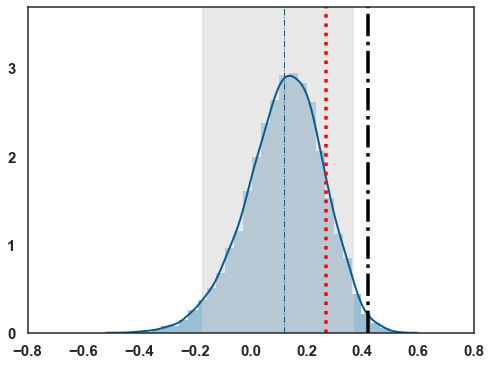

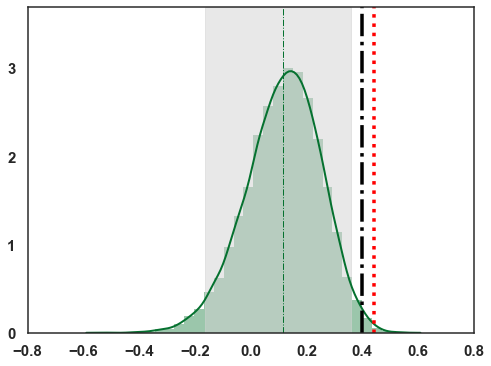

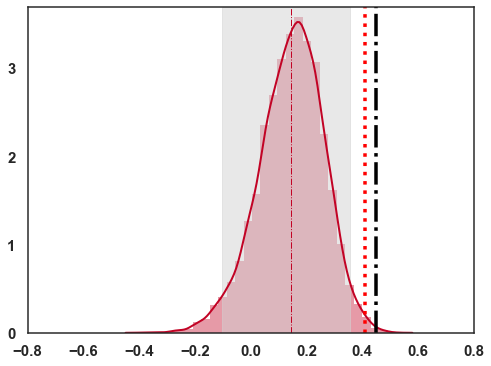

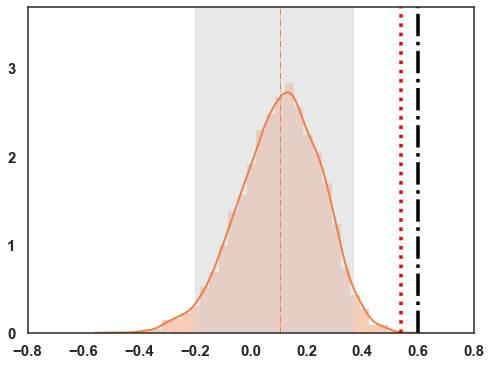

In [108]:
def plt_permutation(mu_corr, pc_corr, null_distribution, color1, fname):

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    #sns.set(style="white", palette="muted", color_codes=True)
    sns.set_style("white")
    g = sns.distplot(null_distribution, color=color1, hist=1, bins = 30, norm_hist=1, 
                     kde_kws={'linewidth': 2} )
    null_mu = np.mean(null_distribution)
    null_sd = np.std(null_distribution)
    null_05 = np.percentile(null_distribution, 2.5)
    null_95 = np.percentile(null_distribution, 97.5)
    
    plt.axvline(null_mu, color=color1, linestyle='-.', linewidth=1)
    #plt.axvline(np.percentile(null_distribution, 2.5), color='k', linestyle='-.', linewidth=1)
    #plt.axvline(np.percentile(null_distribution, 97.5), color='k', linestyle='-.', linewidth=1)
    plt.axvspan(null_05,null_95, alpha=0.5, color='lightgray')
        
    print null_mu
    print null_sd
    print null_05
    print null_95
    
    #plt.arrow(null_mu, 0.5, null_05, 0, fc="r", ec="r",head_width=0.1, head_length=0.01,linewidth=3)
    #plt.arrow(null_mu, 0.5, null_95, 0, fc="r", ec="r",head_width=0.01, head_length=0.01,linewidth=3)

    plt.axvline(mu_corr, color='r', linestyle=':', linewidth=3.5)
    plt.axvline(pc_corr, color='k', linestyle='-.', linewidth=3.5)

    #plt.arrow(mu_corr, 3, 0.0, -2.75, fc="r", ec="r",head_width=0.025, head_length=0.1,linewidth=3)
    #plt.arrow(pc_corr, 3, 0.0, -2.75, fc="b", ec="b",head_width=0.025, head_length=0.1,linewidth=3)
    
    plt.yticks([0,1,2,3])
    plt.xlim(-.8,.8)
    plt.ylim(0,3.7)
    plt.tick_params(axis='x', pad=12)
    plt.tick_params(axis='y', pad=12)
    plt.setp(ax.spines.values(), linewidth=1.5)
    
    plt.xticks(fontsize=15, weight='bold')
    plt.yticks(fontsize=15, weight='bold')
    
    plt.savefig(os.path.join(save_fig_dir, 'permute_STRM_%s'%fname), bbox_inches='tight', transparent=1, dpi = 300)
    
plt_permutation(MU_R_STRM_IH, PC_R_STRM_IH, MU_NULL_STRM_IH, B[0], 'IRON_H'  )
plt_permutation(MU_R_STRM_ID, PC_R_STRM_ID, MU_NULL_STRM_ID, G[0], 'IRON_D'  )
plt_permutation(MU_R_STRM_T2, PC_R_STRM_T2, MU_NULL_STRM_T2, R[0], 'IRON_T2' )
plt_permutation(MU_R_STRM_FR, PC_R_STRM_FR, MU_NULL_STRM_FR, O[0], 'FERRITIN')

# Get coords for Visualizing wells in 3d

In [109]:
# Get coords for visualizing wells in 3d
df_motor  =  make_corr(df_PC1,'IRON_H',  'STR3_MOTOR_tstat_CP_1mm', B[0], (0.14,1.4), fname=None, plot = 0)
df_limbic =  make_corr(df_PC1,'IRON_H',  'STR3_LIMBIC_tstat_CP_1mm', B[0], (0.14,1.4), fname=None, plot = 0)
df_exec   =  make_corr(df_PC1,'IRON_H',  'STR3_EXEC_tstat_CP_1mm', B[0], (0.14,1.4), fname=None, plot = 0)

IRON_H STR3_M 0.42 0.0009798543
IRON_H STR3_L 0.26 0.0846993777
IRON_H STR3_E 0.09 0.5179249451


In [68]:
df_motor.to_csv(os.path.join(ahba_dir,  'wells_motor.csv'))
df_limbic.to_csv(os.path.join(ahba_dir, 'wells_limbic.csv'))
df_exec.to_csv(os.path.join(ahba_dir,   'wells_exec.csv'))